In [ ]:
from google.colab import drive

drive.mount('gdrive')

Mounted at gdrive


In [ ]:


import numpy as np
import pandas as pd

file_path = 'gdrive/My Drive/data.csv'

df = pd.read_csv(file_path)

In [ ]:
df


,Unit,Total Cost of Sales,Gross Profit,Total Labor,Total Prime Costs,Total Controllable Costs,Controllable Profit,Total Non-controllable Costs,Store EBITDA
0,00040302CD88,22747,67205,7898,30645,34531,32674,7269,25405
1,00040302CD88,22934,67660,9330,32264,29278,38382,7740,30642
2,00040302CD88,21822,60087,8033,29855,27747,32340,6944,25396
3,00040302CD88,23055,64363,49056,72111,71261,-6898,7184,-14082
4,00040302CD88,23669,67440,42535,66204,64950,2490,6218,-3728
...,...,...,...,...,...,...,...,...,...
211,0004030BEB57,109793,264704,94918,204711,139868,124836,91047,33789
212,0004030BEB57,121644,303041,114744,236388,156370,146671,120684,25987
213,0004030BEB57,112525,250680,103340,215865,148349,102331,86448,15883
214,0004030BEB57,110105,247506,105045,215150,141023,106483,84785,21698


In [ ]:
df2 = df.groupby('Unit')['Total Cost of Sales','Gross Profit'].mean()
df2

<ipython-input-5-e0e37e90c538>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df.groupby('Unit')['Total Cost of Sales','Gross Profit'].mean()


,Total Cost of Sales,Gross Profit
Unit,,
00040302CD88,33448.625000,77875.666667
00040302CE36,62354.833333,168642.750000
00040302CF03,41093.958333,110230.250000
00040302CF28,52398.125000,131080.291667
00040302D006,18120.833333,47248.291667
00040302D014,65493.125000,188806.750000
0004030A635E,134110.875000,380002.250000
0004030B92EE,87777.166667,236223.916667
0004030BEB57,104943.833333,289412.500000


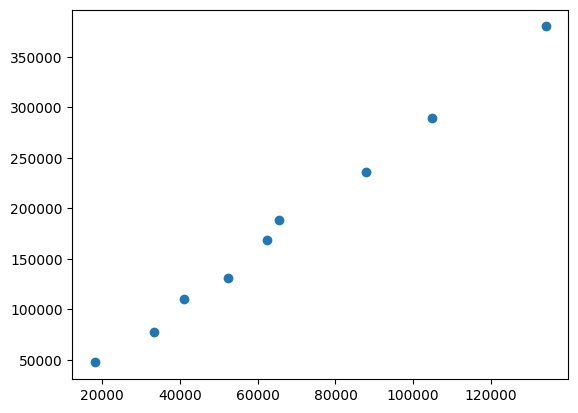

In [ ]:
###Average value of 'Total Cost of Sales'against 'Gross Profit' for each account

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(df2['Total Cost of Sales'], df2['Gross Profit'], marker='o', linestyle='', label='Scatter Points')
plt.show()

<Axes: xlabel='Total Cost of Sales', ylabel='Gross Profit'>

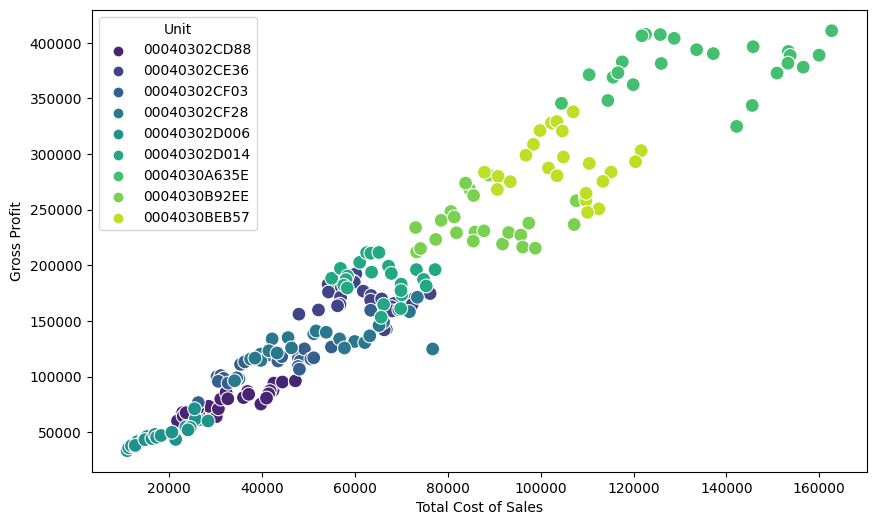

In [ ]:
###'Total Cost of Sales' against 'Gross Profit' for each account for all the period
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Total Cost of Sales', y='Gross Profit', hue='Unit', palette='viridis', s=100)

In [ ]:
np.polyfit(df2['Total Cost of Sales'], df2['Gross Profit'], 2)

array([ 1.38622432e-06,  2.68093882e+00, -5.41286057e+03])

#Comparison of effciency across all DMUs


In [ ]:
###pip install pyDEA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for xlwt-future: filename=xlwt_future-0.8.0-py3-none-any.whl size=3258153 sha256=0b66c1679195bfc5e2e69a0b89d8ef3ff8381370f9699a264c1822e33a0857fd
  Stored in directory: /root/.cache/pip/wheels/ed/fc/a9/1ef5279649ad23b8fc75573ac3c87d998d282d7326265d1904
Successfully built xlwt-future


In [ ]:
###pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.9 MB/s eta 0:00:00


In [ ]:
import pyDEA
import deap

In [ ]:
import numpy as np
from deap import creator, base, tools, algorithms

# Define the fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create the toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Set up the evaluation function
def evaluate(individual):
    # DEA requires inputs and outputs. The output is Gross Profit, the input is Total Cost of Sales
    output = df2['Gross Profit'].to_numpy()
    input = df2['Total Cost of Sales'].to_numpy()

    # Calculate efficiency for each DMU
    efficiencies = output / (input * np.array(individual))
    return np.mean(efficiencies),

# Register the evaluation and selection methods
toolbox.register("evaluate", evaluate)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the genetic algorithm
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.0, mutpb=0.2, ngen=40,
                               stats=stats, halloffame=hof, verbose=True)

# Extract and print the most efficient individual
best_ind = hof[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




gen	nevals	avg   	std    	min    	max    
0  	100   	41.427	231.093	2.68352	2258.29
1  	21    	68.2465	246.613	-89.4697	2258.29
2  	17    	208.664	405.481	-6.17637	2258.29
3  	21    	359.044	481.925	4.40246 	2258.29
4  	20    	709.153	690.064	-2.66252	2258.29
5  	22    	1243.64	904.357	-25.1394	2258.29
6  	17    	1923.72	718.483	-49.0968	2258.29
7  	11    	2172.54	422.205	-18.8586	2258.29
8  	21    	2145.28	492.584	-6.84567	2258.29
9  	12    	2213.08	316.435	-7.48032	2258.29
10 	22    	2145.5 	491.648	-7.14898	2258.29
11 	22    	2190.44	385.793	-5.92248	2258.29
12 	18    	2145.37	492.199	-11.9379	2258.29
13 	16    	2168.11	441.76 	-6.78771	2258.29
14 	16    	2213.1 	316.303	-4.86031	2258.29
15 	16    	2123.05	535.302	-4.37132	2258.29
16 	16    	2213.04	316.729	-4.88281	2258.29
17 	17    	2122.66	536.845	-8.49459	2258.29
18 	17    	2212.96	317.323	-10.1615	2258.29
19 	14    	2213.15	315.954	1.05205 	2258.29
20 	23    	2167.76	443.48 	-9.04351	2258.29
21 	23    	2167.97	442.456	-3.72274	

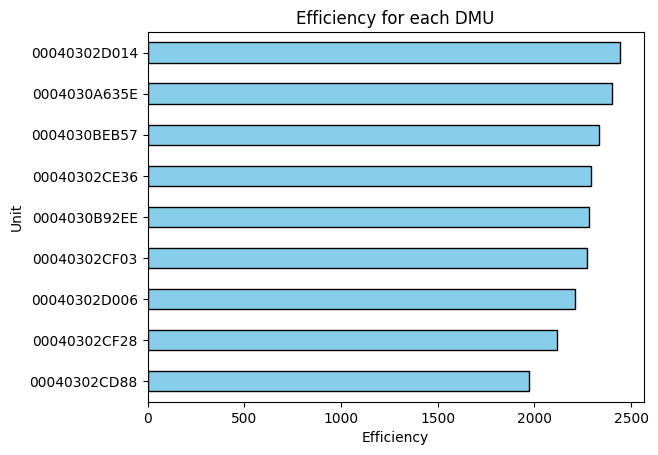

In [ ]:
import matplotlib.pyplot as plt

# Calculate the efficiency for each DMU
df2['Efficiency'] = df2['Gross Profit'] / (df2['Total Cost of Sales'] * np.array(best_ind))

# Sort DataFrame by 'Efficiency' column from high to low
df2 = df2.sort_values(by='Efficiency', ascending=False)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot efficiencies
df2['Efficiency'].plot(kind='barh', ax=ax, color='skyblue', edgecolor='k')

# Invert y-axis to have units in descending order
ax.invert_yaxis()

# Set labels and title
ax.set_xlabel('Efficiency')
ax.set_ylabel('Unit')
ax.set_title('Efficiency for each DMU')

# Show the plot
plt.show()
